# Image-Generation-Finetuning

## Install dependencies

In [3]:
!pip install -qq diffusers datasets accelerate

In [13]:
!pip install -r requirements.txt

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------------------- - 7.9/8.1 MB 50.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 38.8 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 33.3 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- ----------------------

In [1]:
from diffusers import StableDiffusionPipeline, DDPMScheduler
from diffusers import UNet2DConditionModel, AutoencoderKL, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
from accelerate import Accelerator
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

## Stable Diffusion model initialization from HuggingFace

In [2]:
pretrained_model = "CompVis/stable-diffusion-v1-4"
device = "cpu"

pipe = StableDiffusionPipeline.from_pretrained(pretrained_model).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

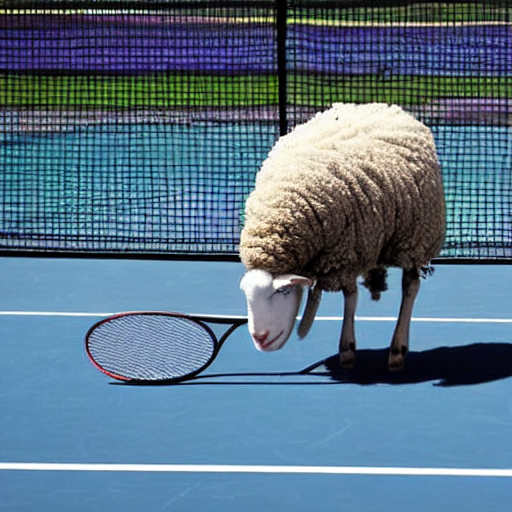

In [5]:
prompt = "an image of a sheep playing tennis with a racket"
image = pipe(prompt).images[0]

image

## Previous preparation steps

For this project we will be uploading only the training part of the images from the dataset *[oldbookillustrations](https://huggingface.co/datasets/gigant/oldbookillustrations)*. This is done to reduce training time, less memory and disk consumption and to be more manageable to experiment our finetuning.

In [3]:
train_dataset = load_dataset("gigant/oldbookillustrations", split="train[:300]")

print(train_dataset)


Generating train split:   0%|          | 0/4154 [00:00<?, ? examples/s]

Dataset({
    features: ['rawscan', '1600px', 'info_url', 'info_src', 'info_alt', 'artist_name', 'artist_birth_date', 'artist_death_date', 'artist_countries', 'book_title', 'book_authors', 'book_publishers', 'date_published', 'openlibrary-url', 'tags', 'illustration_source_name', 'illustration_source_url', 'illustration_subject', 'illustration_format', 'engravers', 'image_title', 'image_caption', 'image_description', 'rawscan_url', '1600px_url'],
    num_rows: 300
})


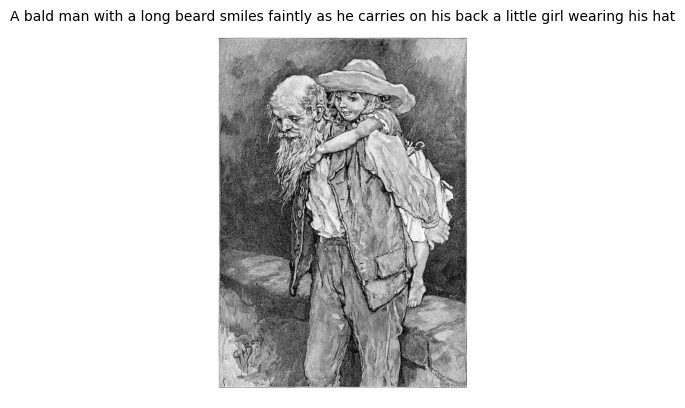

In [15]:
import matplotlib.pyplot as plt

image = train_dataset[0]["1600px"]
caption = train_dataset[0]["info_alt"]

plt.imshow(image)
plt.axis("off")
plt.title(caption, fontsize=10)
plt.show()

In [19]:
rgb = True

for img in train_dataset["1600px"]:
    if img.mode != "RGB":
        print("There are different images using a non RGB convention")
        rgb = False

if rgb:
    print("Everything following the RGB convention")

Everything following the RGB convention


When reading dataset documentation, we can see that the images are not necessarily the same size. Tis can be read at the feature description:

'*1600px*': the cleaned image, resized to a width of 1600 pixels (height can vary)

In [20]:
resolution = 512
image_transforms = transforms.Compose([
    transforms.Resize((resolution, resolution)),             # resizing
    transforms.CenterCrop(resolution),                       # como son de diferentes tamaños centramos las imágenes antes de recortarla
    transforms.ToTensor(),                                   # convertir a tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # normalizacion
])

Imagen transformada:


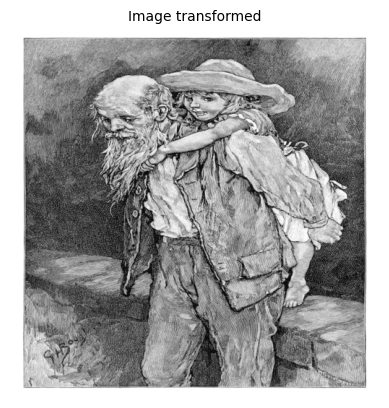

In [26]:
original_image = train_dataset[0]["1600px"]
transformed_image = image_transforms(original_image)
# transformed_pil_image = transforms.ToPILImage()(transformed_image)

def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0,1)

img_show = denormalize(transformed_image).permute(1,2,0)

print("Imagen transformada:")
plt.imshow(img_show)
plt.axis("off")
plt.title("Image transformed", fontsize=10)
plt.show()